###                                                                                         Name: Sharon Laurance Muthipeedika 
###                                                                                         Matriculation No: 312486

## Exercise 1: Implement Decision Tree

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df=pd.read_csv("C:\\Users\\Sharon\\ML_LAB\\Lab 9\\iris.data",header=None,delimiter=',')

In [3]:
df.columns =['sepal_length', 'sepal_width', 'petal_length', 'petal_width','target']

In [4]:
df['target']=df.target.astype("category").cat.codes

#### Target class
 - Iris Setosa = 0
 - Iris Versicolour = 1
 - Iris Virginica = 2

In [5]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=3116)

In [8]:
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train, test_size=0.12, random_state=3116)

### Part A:  Basic working with MCR

In [9]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [25]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                print("Decision step at which split occurs with threshold ",best_split["threshold"])
                #Find out the probability of each class at this time and store in array
                self.find_probability(Y)
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def find_probability(self, y):

        
        uniqw, inverse = np.unique(y, return_inverse=True)
        hist=np.bincount(inverse)
        
        ps=hist/len(y)
        print("Probability Array",ps)
        plt.hist(ps, bins=6)
        plt.title("Probability of Y")
        plt.show()
        plt.hist(y)
        plt.title("Iris class Target distribitution for each class")
        plt.show()
        
#         x = np.arange(3)
        
#         plt.bar(x, height=ps)
#         plt.xticks(x, ['Iris Setosa','Iris Versicolour','Iris Virginica'])
#         plt.show()
        
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    

    def information_gain(self, parent, l_child, r_child):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        
        gain = self.misclassification_rate(parent) - (weight_l*self.misclassification_rate(l_child) + weight_r*self.misclassification_rate(r_child))
        return gain
     
    def misclassification_rate(self, y):
        #Here class having majority label would be predicted. So accuracy would be majority class/total length
        #Error percentage would be 1- accuracy
#         print(y)
        uniqw, inverse = np.unique(y, return_inverse=True)
        hist=np.bincount(inverse)
#         print(hist)
        accuracy=np.amax(hist)/len(y)
        error=1-accuracy
#         print(error)
        return error
   
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            if (tree.feature_index==0):
                
                print("sepal_length", "<=", tree.threshold, "?", tree.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
            elif (tree.feature_index==1):
                print("sepal_width", "<=", tree.threshold, "?", tree.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
                
            elif (tree.feature_index==2):
                print("petal_length", "<=", tree.threshold, "?", tree.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
            elif (tree.feature_index==3):
                print("petal_width", "<=", tree.threshold, "?", tree.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
    
    
    def bfs_traversal(self, tree=None):
        arr=[]
        if not tree:
            tree = self.root
        if tree.value is not None:
#             print("Leaf Node is",tree.value)
            arr.append(tree.value)
        else:
            self.bfs_traversal(tree.left)
            self.bfs_traversal(tree.right)  
        return arr
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
#         print(self.root)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: 
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
        
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(accuracy)
    return accuracy

#### 1.At each decision step (or split) present the probability of each class using histogram (properly labeled figure)

Decision step at which split occurs with threshold  1.9
Probability Array [0.34234234 0.35135135 0.30630631]


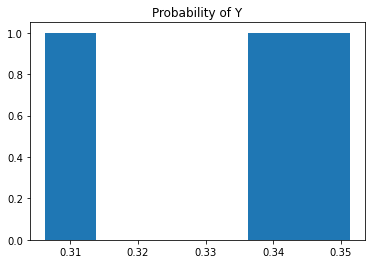

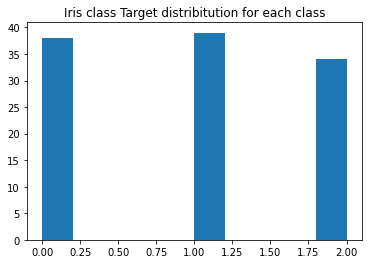

Decision step at which split occurs with threshold  4.7
Probability Array [0.53424658 0.46575342]


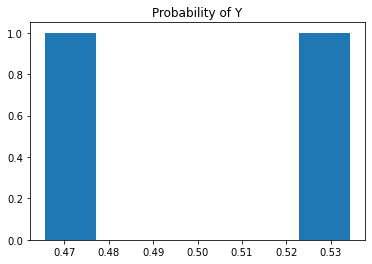

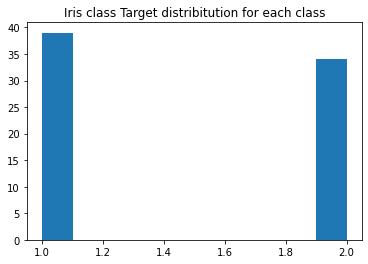

Decision step at which split occurs with threshold  1.6
Probability Array [0.97142857 0.02857143]


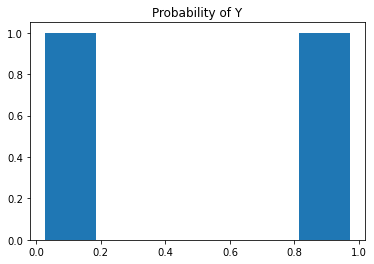

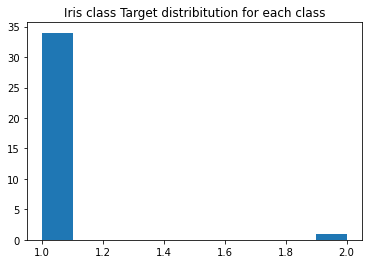

Decision step at which split occurs with threshold  5.7
Probability Array [0.13157895 0.86842105]


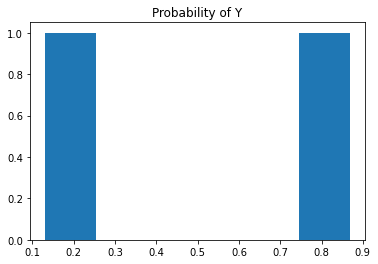

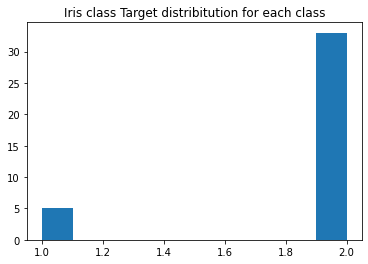

Decision step at which split occurs with threshold  5.0
Probability Array [0.13888889 0.86111111]


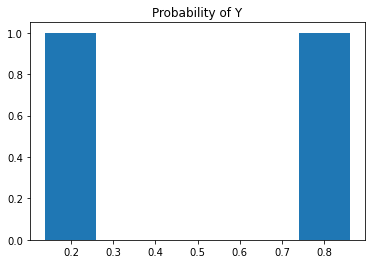

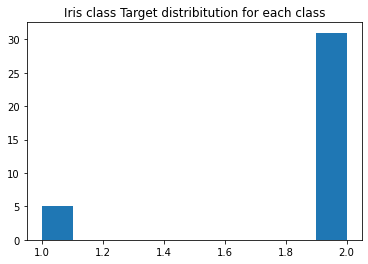

In [26]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,y_train)

#### 2. Print your tree using a breath first tree traversal.

In [18]:
classifier.print_tree()
arr=classifier.bfs_traversal()
print("BFS Traversal of Tree is",arr)

petal_length <= 1.9 ? 0.34234234234234234
 left:0.0
 right:petal_length <= 4.7 ? 0.3835616438356164
  left:petal_width <= 1.6 ? 0.02857142857142858
    left:1.0
    right:2.0
  right:sepal_length <= 5.7 ? 2.7755575615628914e-17
    left:2.0
    right:petal_length <= 5.0 ? 0.02777777777777775
        left:1.0
        right:2.0
BFS Traversal of Tree is [0.0, 1.0, 2.0, 2.0, 1.0, 2.0]


#### 3. On the validation-set measure the cross entropy loss (i.e. logloss, note that this time problem is not binary classification). Here class labels are returned by prediction therefore accuracy is given for dataset. Probabilities are not returned so cross entropy loss is not calculated



In [20]:
Y_pred = classifier.predict(X_val) 
acc=accuracy_score(y_val, Y_pred)
print("Accuracy Score for Validation Class",acc)

Accuracy Score for Validation Class 0.9375


### Part B: Experimenting with other Quality-criterion:

#### Modify the Quality-criterion to Information Gain using entropy

In [21]:
class DecisionTreeClassifier_Info():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    

   
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            if (tree.feature_index==0):
                
#                 print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
                print("sepal_length", "<=", tree.threshold, "?", tree.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
            elif (tree.feature_index==1):
                print("sepal_width", "<=", tree.threshold, "?", tree.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
                
            elif (tree.feature_index==2):
                print("petal_length", "<=", tree.threshold, "?", tree.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
            elif (tree.feature_index==3):
                print("petal_width", "<=", tree.threshold, "?", tree.info_gain)
                print("%sleft:" % (indent), end="")
                self.print_tree(tree.left, indent + indent)
                print("%sright:" % (indent), end="")
                self.print_tree(tree.right, indent + indent)
    
    
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
#         print(self.root)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: 
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
        
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(accuracy)
    return accuracy

#### At each decision step, plot the Information Gain.


In [22]:
classifier_info = DecisionTreeClassifier_Info(min_samples_split=3, max_depth=3)

classifier_info.fit(X_train,y_train)
classifier_info.print_tree()


petal_length <= 1.9 ? 0.9270425482501283
 left:0.0
 right:petal_length <= 4.7 ? 0.6144520763280722
  left:petal_width <= 1.6 ? 0.18717625687320816
    left:1.0
    right:2.0
  right:petal_width <= 1.8 ? 0.19926741017824018
    left:petal_length <= 5.1 ? 0.2516291673878229
        left:2.0
        right:2.0
    right:2.0


In [23]:
Y_pred = classifier_info.predict(X_val) 
accuracy_score(y_val, Y_pred)

1.0

#### Compare the validation set results for both Quality-criterion, output one value for test-set.For validation set as seen Misclassification criterion is not that good.Misclassification criterion just compares True values with majority class label. And error is calculated. Better Quality Criterion is Information gain by taking entropy. Final results will be seen on test set.

In [24]:
Y_pred = classifier.predict(X_test) 
print("Test Accuracy Score with MCR Quality Criterion",accuracy_score(y_test, Y_pred))
Y_pred = classifier_info.predict(X_test) 
print("Test Accuracy Score with Information Gain Quality Criterion",accuracy_score(y_test, Y_pred))

Test Accuracy Score with MCR Quality Criterion 0.9130434782608695
Test Accuracy Score with Information Gain Quality Criterion 0.9565217391304348


#### Even according to test dataset we can see Information Gain performs better as Quality Criterion with accuracy being 95%.

#### References
 - https://github.com/Suji04/ML_from_Scratch/blob/master/decision%20tree%20classification.ipynb
 - https://datatofish.com/plot-histogram-python/